In [9]:
import random
import numpy as np
import copy
cases = [
    {"p1_rate": 0.1, "p1_cost": 4, "p1_test": 2,
     "p2_rate": 0.1, "p2_cost": 18, "p2_test": 3, 
     "product_rate":0.1,"assemble": 6, "product_test": 3,"market": 56, 
     "adjustment_loss": 6, "disassemble_cost": 5},
    ]


In [10]:
class part():
    def __init__(self,fail_rate):
        if np.random.rand()<fail_rate:
            self.ok = False
        else:
            self.ok=True
        self.exist = True
        self.disassemble = 0
    def test(self):
        return self.ok
    def dump(self):
        self.exist=False
        
class product():
    def __init__(self,part1,part2,fail_rate):
        self.part1 = part1
        self.part2 = part2
        if part1 and part2:
            self.ok = False if np.random.rand()<=fail_rate else True
        else:
            self.ok=False
    def test(self):
        return self.part1.ok and self.part2.ok and self.ok

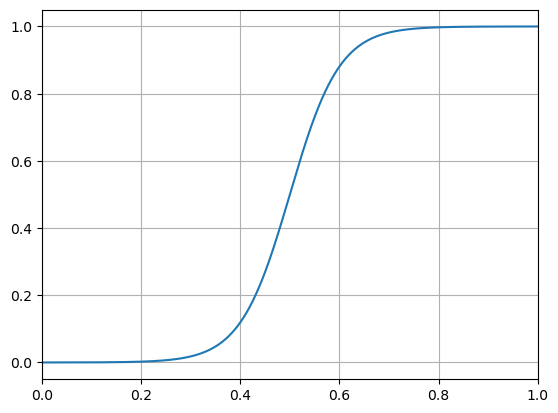

In [11]:
from matplotlib import pyplot as plt
import numpy as np
x = np.linspace(-10,10,int(1e4))
sigma = lambda x:1/(1+np.exp(-20*(x-0.5)))
plt.plot(x,sigma(x))
plt.xlim((0,1))
plt.grid()

In [12]:
sigma(0.75)

0.9933071490757153

In [13]:
sigma(0)

4.5397868702434395e-05

In [14]:
def decision(num_part,case,*,test1,test2,test_product,disassemble):
    all_market = 0
    failure_in_market=0
    cost=0
    income=0
    part1s=[]
    part2s=[]
    dead_stock = []#没有卖出去的product
    stf_rate=1 #满意率
    #购买配件12
    for _ in range(num_part):
        p1 = part(case['p1_rate'])
        p2 = part(case['p2_rate'])
        cost = cost + case['p1_cost']
        cost = cost + case['p2_cost']
        
        if test1 or p1.disassemble>=1:
            cost = cost + case['p1_test']
            if p1.test():
                part1s.append(copy.copy(p1))
            else:
                p1.dump()
        else:
            part1s.append(copy.copy(p1))
        if test2 or p2.disassemble>=1:
            cost = cost+case['p2_test']
            if p2.test():
                part2s.append(copy.copy(p2))
            else:
                p2.dump()
        else:
            part2s.append(copy.copy(p2))
            
    #现在开始装配,在part1s和part2s中随机选取一个零件
    len1,len2 = len(part1s),len(part2s)
    while len1 and len2:
        idx1 = random.randint(0,len1-1)
        idx2 = random.randint(0,len2-1)
        cost = cost + case['assemble']
        assembled_product = product(copy.copy(part1s[idx1]),copy.copy(part2s[idx2]),fail_rate=case['product_rate'])
        len1 = len1-1
        len2 = len2-1
        del part1s[idx1]
        del part2s[idx2]
    
    
        if test_product:
            cost += case['product_test']
            if assembled_product.test():
                
                if np.random.rand()<=sigma(stf_rate):
                    all_market+=1
                    income = income + case['market']
                else:
                    dead_stock.append(copy.deepcopy(assembled_product))
                stf_rate = 1-failure_in_market/all_market if not all_market==0 else 1#更新满意率
                
            elif disassemble:
                cost = cost+case['disassemble_cost']
                assembled_product.part1.disassemble+=1
                assembled_product.part2.disassemble+=1
                if assembled_product.part1.disassemble>=1 and assembled_product.part1.test():
                    cost += case['p1_test']
                    part1s.append(copy.copy(assembled_product.part1))
                    len1=len1+1
                if assembled_product.part2.disassemble>=1 and assembled_product.part2.test():
                    cost += case['p2_test']
                    part2s.append(copy.copy(assembled_product.part2))
                    len2 = len2+1
                del assembled_product

        else:
            if np.random.rand()<=sigma(stf_rate):
                all_market+=1
                income = income + case['market']
                if not assembled_product.test():#如果不合格，则需要退货
                    failure_in_market = failure_in_market + 1
                    #print(failure_in_market)
                    income = income - case['market']
                    cost = cost + case['adjustment_loss']
                    if disassemble:       
                        cost = cost+case['disassemble_cost']
                        assembled_product.part1.disassemble+=1
                        assembled_product.part2.disassemble+=1
                        if assembled_product.part1.disassemble>=1 and assembled_product.part1.test():
                            cost += case['p1_test']
                            part1s.append(copy.copy(assembled_product.part1))
                            len1=len1+1
                        if assembled_product.part2.disassemble>=1 and assembled_product.part2.test():
                            cost += case['p2_test']
                            part2s.append(copy.copy(assembled_product.part2))
                            len2 = len2+1
                        del assembled_product
            else:
                dead_stock.append(copy.deepcopy(assembled_product))
            stf_rate = 1-failure_in_market/all_market if not all_market==0 else 1#更新满意率
                
    return income - cost,failure_in_market,stf_rate

In [15]:
to_bi = lambda i:format(i,'04b')
plans=[{'test1':int(to_bi(i)[0]),'test2':int(to_bi(i)[1]),'test_product':int(to_bi(i)[2]),'disassemble':int(to_bi(i)[3])} for i in range(16) ]
for case in cases:
    """p1_rate = case['p1_rate']
    p1_cost = case['p1_cost']
    p1_test = case['p1_test']
    p2_rate,p2_cost,p2_test = case["p2_rate"], case["p2_cost"], case["p2_test"]
    product_rate, assemble, product_test, market =case["product_rate"],case["assemble"], case["product_test"],case["market"]
    adjustment_loss, disassemble_cost = case["adjustment_loss"], case["disassemble_cost"]"""
    for i, plan in enumerate(plans,1):
        print('plan:{}'.format(i),plan)
        profit,failure,stf_rate = decision(num_part=100000,case=case,**plan)
        print('profit:'+str(profit),'failed product in market:{} satisfacation rate:{}'.format(failure,stf_rate))

plan:1 {'test1': 0, 'test2': 0, 'test_product': 0, 'disassemble': 0}
profit:1095638 failed product in market:26591 satisfacation rate:0.731417605171456
plan:2 {'test1': 0, 'test2': 0, 'test_product': 0, 'disassemble': 1}
profit:1150066 failed product in market:25764 satisfacation rate:0.7538667303558634
plan:3 {'test1': 0, 'test2': 0, 'test_product': 1, 'disassemble': 0}
profit:983800 failed product in market:0 satisfacation rate:1.0
plan:4 {'test1': 0, 'test2': 0, 'test_product': 1, 'disassemble': 1}
profit:1522861 failed product in market:0 satisfacation rate:1.0
plan:5 {'test1': 0, 'test2': 1, 'test_product': 0, 'disassemble': 0}
profit:924258 failed product in market:17084 satisfacation rate:0.8095259331935959
plan:6 {'test1': 0, 'test2': 1, 'test_product': 0, 'disassemble': 1}
profit:1566342 failed product in market:20019 satisfacation rate:0.8176377350240489
plan:7 {'test1': 0, 'test2': 1, 'test_product': 1, 'disassemble': 0}
profit:786120 failed product in market:0 satisfacation

In [16]:
case_q3 = {
    'p1':{ 'fail':0.1,'cost':2,'test':1},
    'p2':{ 'fail':0.1,'cost':2,'test':1},
    'p3':{ 'fail':0.1,'cost':2,'test':1},
    'p4':{ 'fail':0.1,'cost':2,'test':1},
    'p5':{ 'fail':0.1,'cost':2,'test':1},
    'p6':{ 'fail':0.1,'cost':2,'test':1},
    'p7':{ 'fail':0.1,'cost':2,'test':1},
    'p8':{ 'fail':0.1,'cost':2,'test':1},
    'h1':{'fail':0.1,'cost':8,'test':4,'disassemble':6},
    'h2':{'fail':0.1,'cost':8,'test':4,'disassemble':6},
    'h3':{'fail':0.1,'cost':8,'test':4,'disassemble':6},
    'f':{'fail':0.1,'cost':8,'test':6,'disassemble':10,'market':200,'adjustment':40}#成品
}